In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/filt_global/aal_balanced_test_data.csv
/kaggle/input/train-data/filt_global/dosen_balanced_test_data.csv
/kaggle/input/train-data/filt_global/cc400_balanced_train_data.csv
/kaggle/input/train-data/filt_global/cc200_balanced_train_data.csv
/kaggle/input/train-data/filt_global/cc400_balanced_test_data.csv
/kaggle/input/train-data/filt_global/cc200_balanced_test_data.csv
/kaggle/input/train-data/filt_global/aal_balanced_train_data.csv
/kaggle/input/train-data/filt_global/dosen_balanced_train_data.csv
/kaggle/input/train-data/filt_noglobal/aal_balanced_test_data.csv
/kaggle/input/train-data/filt_noglobal/dosen_balanced_test_data.csv
/kaggle/input/train-data/filt_noglobal/cc400_balanced_train_data.csv
/kaggle/input/train-data/filt_noglobal/cc200_balanced_train_data.csv
/kaggle/input/train-data/filt_noglobal/cc400_balanced_test_data.csv
/kaggle/input/train-data/filt_noglobal/cc200_balanced_test_data.csv
/kaggle/input/train-data/filt_noglobal/aal_balanced_train_data.c

In [2]:
!pip install tensorflow-model-optimization
!pip install numba 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, Input, Add, ZeroPadding1D, BatchNormalization, LSTM, Bidirectional, TimeDistributed,Activation
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers
from numba import cuda
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow_model_optimization.python.core.keras.compat import keras
from numba import cuda 
from tensorflow.keras.regularizers import l1, l2
%matplotlib inline

def get_model(n_features,  channels, n_outputs): #sequential model DNN 
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(n_features,  channels)),
        # keras.layers.Conv1D(filters=64, kernel_size=5, activation='elu'),
        # keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(), #128, 64,32,16,16,8,8
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l1(0.0026)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(n_outputs, activation='softmax'),
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_crossentropy 72%

    return model

def get_data(train_file, test_file):


    train_df = pd.read_csv(train_file)
    X_train = train_df.drop('y', axis=1).values
    y_train = train_df.y.values
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
    y_train = tf.keras.utils.to_categorical(y_train)
    test_df = pd.read_csv(test_file)
    X_test = test_df.drop('y', axis=1).values
    y_test = test_df.y.values
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_test = tf.keras.utils.to_categorical(y_test)


    return X_train, y_train, X_test, y_test


def get_acc(X_train, y_train, X_test, y_test, model, name):
    H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1) # , callbacks=[early_stopping]
    y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)

    print('classification report of CC400')
    y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
    report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
    print(report)
    conf_mat = confusion_matrix(y_classes, y_pred)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.savefig(f'/kaggle/working/{name}_confusion_matrix.png')

    fig, ax = plt.subplots(1,1)
    plt.plot(H.history["accuracy"])
    plt.plot(H.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(f'/kaggle/working/{name}_accuracy.png')

    fig, ax = plt.subplots(1,1)
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(f'/kaggle/working/{name}_loss.png')

2024-09-09 06:28:46.127969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 06:28:46.128075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 06:28:46.257260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# CC200

Epoch 1/50


I0000 00:00:1725863377.200335      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 25s 26ms/step - loss: 1.2321 - accuracy: 0.5239 - val_loss: 0.9860 - val_accuracy: 0.7049
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.8745 - accuracy: 0.7864 - val_loss: 0.6717 - val_accuracy: 0.9262
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.6252 - accuracy: 0.9083 - val_loss: 0.5375 - val_accuracy: 0.9344
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.4782 - accuracy: 0.9384 - val_loss: 0.4379 - val_accuracy: 0.9344
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.3968 - accuracy: 0.9422 - val_loss: 0.3672 - val_accuracy: 0.9426
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.3400 - accuracy: 0.9548 - val_loss: 0.3318 - val_accuracy: 0.9426
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.3055 - accuracy: 0.9585 - val_loss: 0.3108 - val_accuracy: 0.9426
Epoch 8/50
50/50 [===========

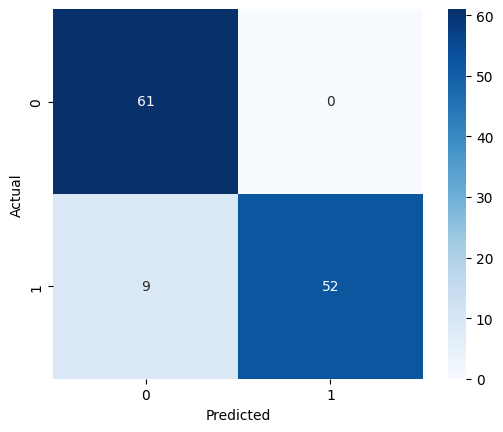

<Figure size 640x480 with 0 Axes>

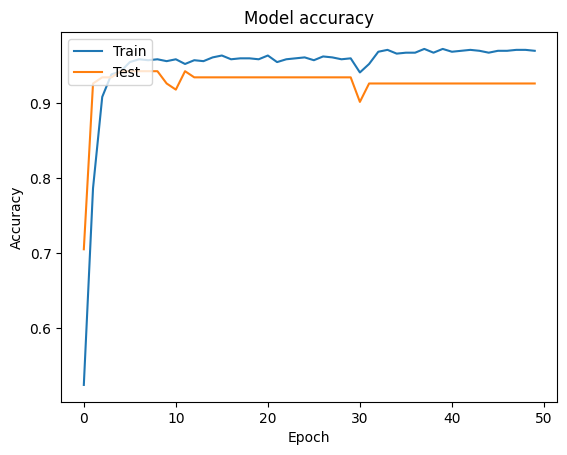

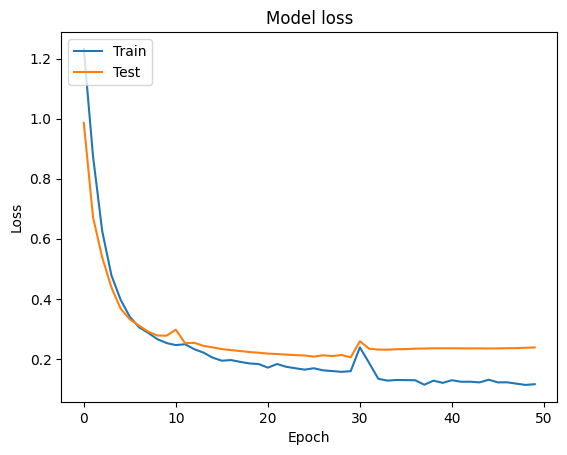

In [4]:
#Load data
X_train, y_train, X_test, y_test = get_data('/kaggle/input/train-data/filt_noglobal/cc200_balanced_train_data.csv',
         '/kaggle/input/train-data/filt_noglobal/cc200_balanced_test_data.csv')

strategy = tf.distribute.MirroredStrategy()
n_timesteps, n_features,  channels,  n_outputs = X_train.shape[0], X_train.shape[1], 1,  y_train.shape[1]

#Model init
with strategy.scope():
# model = get_model(76636, 1, 2)
    model = get_model(n_features,  channels, n_outputs)

#train
get_acc(X_train, y_train, X_test, y_test, model, 'CC200')

# print(model.summary())
# model.save('/kaggle/working/cc200_model.h5')

# #quantization part
# from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print(q_aware_model.summary())


# H2 = q_aware_model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1) #Model Training

# y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of CC200 with quantization')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)

# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/cc200_lite_confusion_matrix.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history["accuracy"])
# plt.plot(H2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/cc200_lite_accuracy.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history['loss'])
# plt.plot(H2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/cc200_lite_loss.png')
# q_aware_model.save('/kaggle/working/cc200_quantized_model.h5')


# #tflite part

# converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# quantized_tflite_model = converter.convert()

# interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
# interpreter.allocate_tensors()

# #testing tflite
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# y_pred = []
# for data in X_test:
#     input_data  = data.astype(np.float32).reshape(1, n_features,1)
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])
#     y_pred.append(np.argmax(output_data))

# # y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of CC200 with tflite quentized')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)
# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/cc200_tflite_confusion_matrix.png')

# with open('/kaggle/working/cc200_quantized_tflite_model.tflite', 'wb') as f:
#     f.write(quantized_tflite_model)

# CC400

Epoch 1/50
50/50 [==============================] - 4s 26ms/step - loss: 1.2382 - accuracy: 0.5682 - val_loss: 0.9005 - val_accuracy: 0.8443
Epoch 2/50
50/50 [==============================] - 0s 10ms/step - loss: 0.8041 - accuracy: 0.8460 - val_loss: 0.4893 - val_accuracy: 0.9508
Epoch 3/50
50/50 [==============================] - 0s 9ms/step - loss: 0.4677 - accuracy: 0.9672 - val_loss: 0.3906 - val_accuracy: 0.9508
Epoch 4/50
50/50 [==============================] - 0s 9ms/step - loss: 0.3231 - accuracy: 0.9836 - val_loss: 0.3206 - val_accuracy: 0.9508
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.2648 - accuracy: 0.9836 - val_loss: 0.2719 - val_accuracy: 0.9590
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.2222 - accuracy: 0.9912 - val_loss: 0.2676 - val_accuracy: 0.9426
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1922 - accuracy: 0.9861 - val_loss: 0.2440 - val_accuracy: 0.9508
Epoch 8/50
50/5

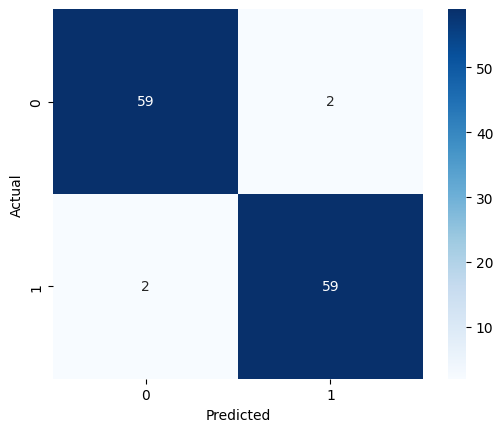

<Figure size 640x480 with 0 Axes>

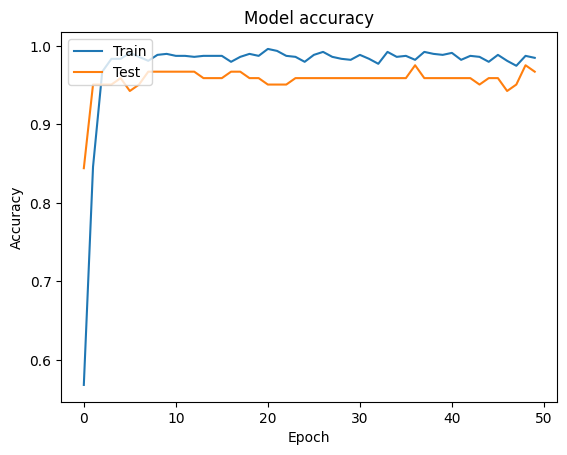

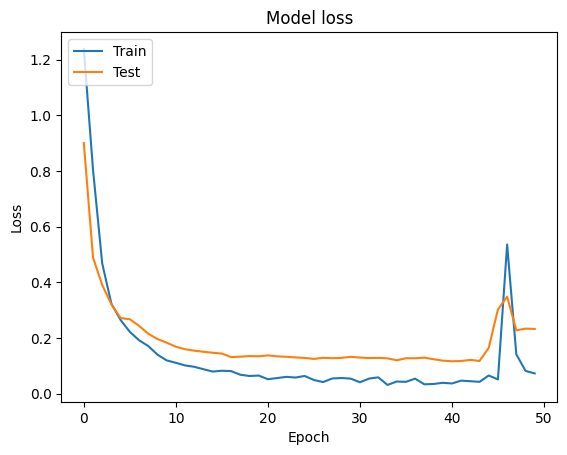

In [5]:
#Load data
X_train, y_train, X_test, y_test = get_data('/kaggle/input/train-data/filt_noglobal/cc400_balanced_train_data.csv',
         '/kaggle/input/train-data/filt_noglobal/cc400_balanced_test_data.csv')

strategy = tf.distribute.MirroredStrategy()
n_timesteps, n_features,  channels,  n_outputs = X_train.shape[0], X_train.shape[1], 1,  y_train.shape[1]

#Model init
with strategy.scope():
# model = get_model(76636, 1, 2)
    model = get_model(n_features,  channels, n_outputs)

#train
get_acc(X_train, y_train, X_test, y_test, model, 'CC400')

# print(model.summary())
# model.save('/kaggle/working/cc400_model.h5')

# #quantization part
# from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print(q_aware_model.summary())


# H2 = q_aware_model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1) #Model Training

# y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of CC400 with quantization')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)

# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/cc400_lite_confusion_matrix.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history["accuracy"])
# plt.plot(H2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/cc400_lite_accuracy.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history['loss'])
# plt.plot(H2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/cc400_lite_loss.png')
# q_aware_model.save('/kaggle/working/cc400_quantized_model.h5')


# #tflite part

# converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# quantized_tflite_model = converter.convert()

# interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
# interpreter.allocate_tensors()

# #testing tflite
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# y_pred = []
# for data in X_test:
#     input_data  = data.astype(np.float32).reshape(1, n_features,1)
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])
#     y_pred.append(np.argmax(output_data))

# # y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of CC400 with tflite quentized')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)
# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/cc400_tflite_confusion_matrix.png')

# with open('/kaggle/working/cc400_quantized_tflite_model.tflite', 'wb') as f:
#     f.write(quantized_tflite_model)

# AAL

Epoch 1/50
50/50 [==============================] - 5s 22ms/step - loss: 1.2333 - accuracy: 0.5254 - val_loss: 1.0969 - val_accuracy: 0.6066
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.9611 - accuracy: 0.7107 - val_loss: 0.6603 - val_accuracy: 0.9426
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5352 - accuracy: 0.9023 - val_loss: 0.4107 - val_accuracy: 0.9508
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.2960 - accuracy: 0.9657 - val_loss: 0.4088 - val_accuracy: 0.9344
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.2135 - accuracy: 0.9810 - val_loss: 0.4497 - val_accuracy: 0.9426
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9810 - val_loss: 0.5573 - val_accuracy: 0.9344
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1541 - accuracy: 0.9810 - val_loss: 0.4402 - val_accuracy: 0.9508
Epoch 8/50
50/50 [=

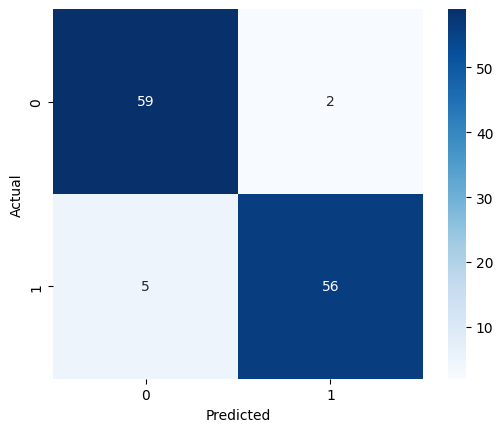

<Figure size 640x480 with 0 Axes>

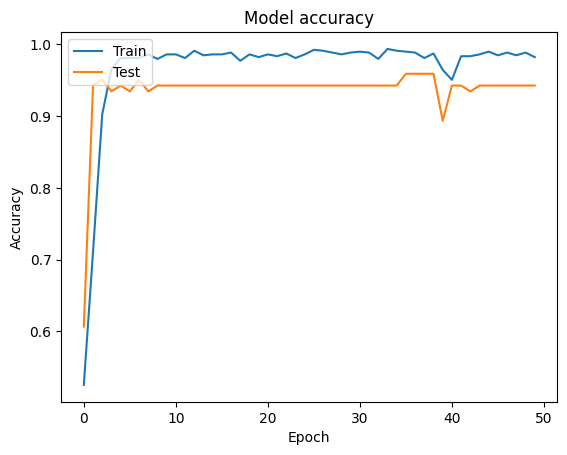

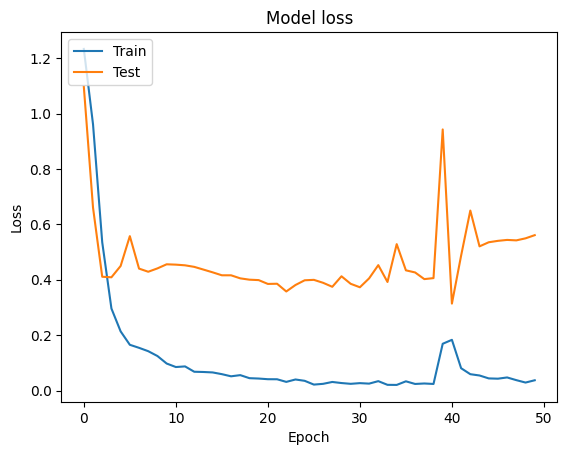

In [6]:
#Load data
X_train, y_train, X_test, y_test = get_data('/kaggle/input/train-data/filt_noglobal/aal_balanced_train_data.csv',
         '/kaggle/input/train-data/filt_noglobal/aal_balanced_test_data.csv')

strategy = tf.distribute.MirroredStrategy()
n_timesteps, n_features,  channels,  n_outputs = X_train.shape[0], X_train.shape[1], 1,  y_train.shape[1]

#Model init
with strategy.scope():
# model = get_model(76636, 1, 2)
    model = get_model(n_features,  channels, n_outputs)

#train
get_acc(X_train, y_train, X_test, y_test, model, 'AAL')

# print(model.summary())
# model.save('/kaggle/working/AAL_model.h5')

# #quantization part
# from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print(q_aware_model.summary())


# H2 = q_aware_model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1) #Model Training

# y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of AAL with quantization')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)

# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/AAL_lite_confusion_matrix.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history["accuracy"])
# plt.plot(H2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/AAL_lite_accuracy.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history['loss'])
# plt.plot(H2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/AAL_lite_loss.png')
# q_aware_model.save('/kaggle/working/AAL_quantized_model.h5')


# #tflite part

# converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# quantized_tflite_model = converter.convert()

# interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
# interpreter.allocate_tensors()

# #testing tflite
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# y_pred = []
# for data in X_test:
#     input_data  = data.astype(np.float32).reshape(1, n_features,1)
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])
#     y_pred.append(np.argmax(output_data))

# # y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of AAL with tflite quentized')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)
# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/AAL_tflite_confusion_matrix.png')

# with open('/kaggle/working/AAL_quantized_tflite_model.tflite', 'wb') as f:
#     f.write(quantized_tflite_model)

# Dosen

Epoch 1/50
49/49 [==============================] - 4s 21ms/step - loss: 1.2440 - accuracy: 0.5000 - val_loss: 1.1268 - val_accuracy: 0.5000
Epoch 2/50
49/49 [==============================] - 0s 7ms/step - loss: 1.0325 - accuracy: 0.5000 - val_loss: 0.9053 - val_accuracy: 0.5164
Epoch 3/50
49/49 [==============================] - 0s 7ms/step - loss: 0.7845 - accuracy: 0.7538 - val_loss: 0.6358 - val_accuracy: 0.8525
Epoch 4/50
49/49 [==============================] - 0s 7ms/step - loss: 0.4980 - accuracy: 0.9171 - val_loss: 0.4778 - val_accuracy: 0.8770
Epoch 5/50
49/49 [==============================] - 0s 7ms/step - loss: 0.3380 - accuracy: 0.9490 - val_loss: 0.3744 - val_accuracy: 0.8934
Epoch 6/50
49/49 [==============================] - 0s 7ms/step - loss: 0.2577 - accuracy: 0.9490 - val_loss: 0.3259 - val_accuracy: 0.8852
Epoch 7/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1906 - accuracy: 0.9643 - val_loss: 0.3252 - val_accuracy: 0.8852
Epoch 8/50
49/49 [=

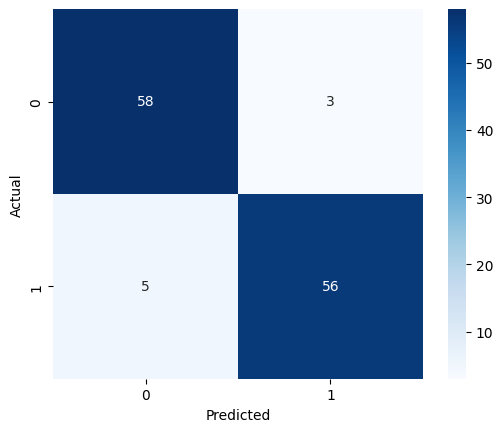

<Figure size 640x480 with 0 Axes>

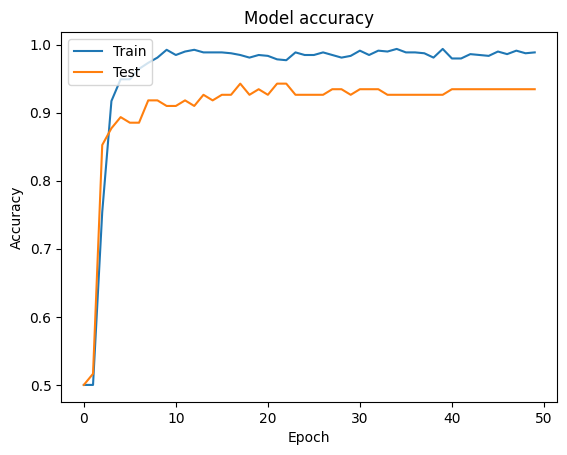

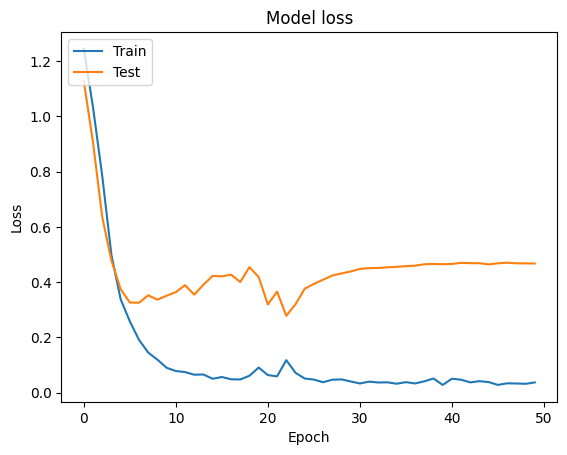

In [7]:
#Load data
X_train, y_train, X_test, y_test = get_data('/kaggle/input/train-data/filt_noglobal/dosen_balanced_train_data.csv',
         '/kaggle/input/train-data/filt_noglobal/dosen_balanced_test_data.csv')

strategy = tf.distribute.MirroredStrategy()
n_timesteps, n_features,  channels,  n_outputs = X_train.shape[0], X_train.shape[1], 1,  y_train.shape[1]

#Model init
with strategy.scope():
# model = get_model(76636, 1, 2)
    model = get_model(n_features,  channels, n_outputs)

#train
get_acc(X_train, y_train, X_test, y_test, model, 'Dosen')

# print(model.summary())
# model.save('/kaggle/working/dosen_model.h5')

# #quantization part
# from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print(q_aware_model.summary())


# H2 = q_aware_model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1) #Model Training

# y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of dosen with quantization')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)

# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/dosen_lite_confusion_matrix.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history["accuracy"])
# plt.plot(H2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/dosen_lite_accuracy.png')

# fig, ax = plt.subplots(1,1)
# plt.plot(H2.history['loss'])
# plt.plot(H2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# plt.savefig(f'/kaggle/working/dosen_lite_loss.png')
# q_aware_model.save('/kaggle/working/dosen_quantized_model.h5')


# #tflite part

# converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# quantized_tflite_model = converter.convert()

# interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
# interpreter.allocate_tensors()

# #testing tflite
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# y_pred = []
# for data in X_test:
#     input_data  = data.astype(np.float32).reshape(1, n_features,1)
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])
#     y_pred.append(np.argmax(output_data))

# # y_pred = np.argmax(q_aware_model.predict(X_test, batch_size=1), axis=1)
# print('classification report of dosen with tflite quentized')
# y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
# report = classification_report(y_classes, y_pred, zero_division=0) #, target_names=['ASD', 'TC']
# print(report)
# conf_mat = confusion_matrix(y_classes, y_pred)
# sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# plt.savefig(f'/kaggle/working/dosen_tflite_confusion_matrix.png')

# with open('/kaggle/working/dosen_quantized_tflite_model.tflite', 'wb') as f:
#     f.write(quantized_tflite_model)